In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)



2024-03-14 15:02:39.799035: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 15:02:39.829300: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 15:02:40.377299: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
game_threshold = 2 # minimum number of games to be in the dataset as a player
test_size = 0.05 # % of the dataset is used for testing
ModelHasBot = True #  if True, the bot is considered as a player - to consider bot statistics in games 2vs3 or 3vs4
timeStart ='2023-06-18' # start date of the dataset
# timeStart=''
present_players = ['Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун','Сеньор','Миша','Сеньор']




# make a set out of the list to remove duplicates
present_players = list(set(present_players))
if len(present_players) > 8:
    print('Too many players')
    exit()


# 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша', 'Ондрей', 'Савва', 'Сеньор', 'Юран'


# Data preprocessing

In [3]:
# dataset = pd.read_csv('data.csv') 
dataset = pd.read_csv('labelled_data.csv') 
columnsPlayers = ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
columnsTeam1 = ["Player1","Player2","Player3","Player4"]
columnsTeam2 = ["Player5","Player6","Player7","Player8"]

In [4]:
dataset["Map"] = dataset["Map"].str.lower() # convert all maps to lower case
dataset['Date'] = pd.to_datetime(dataset['Date'],format='%d.%m.%Y') # convert date to datetime
dataset=dataset.drop_duplicates(subset=['Date','Map']) # drop duplicates with same date and map

dataset.drop(columns=['link','Recorder','vs'],   inplace=True) # drop columns that are not needed
dataset.dropna(subset=['TeamWon'], inplace=True) # drop entries with no map
dataset.to_csv('new_data.csv',index=False) # save the new dataset
#  drop entries which were played before the start date
if timeStart != '':
    dataset = dataset[dataset['Date'] >= timeStart]



### Add column with number of maps in each campaign

In [5]:
map_weights = {
'ливень':5,
'кровавая жатва':5, 
'переход':3,
'мрачный карнавал':5,
'холодный ручей':4,
'похоронный звон':5,
'приход':5,
'смерть в воздухе':5,
'нет милосердию':5,
'вымерший центр':4,
'болотная лихорадка':4,
'последний рубеж':2,
'жертва':3,
'роковой полет':5}

def map_weight(map):
    return map_weights[map]

dataset["Map_weight"] = dataset["Map"].apply(map_weight)
dataset["Map_weight"] = dataset["Map_weight"]/ dataset["Map_weight"].max()# scale weight

dataset.Map.value_counts()

Map
нет милосердию        5
ливень                4
переход               4
мрачный карнавал      4
смерть в воздухе      4
похоронный звон       3
приход                3
вымерший центр        3
кровавая жатва        2
холодный ручей        2
последний рубеж       1
болотная лихорадка    1
роковой полет         1
жертва                1
Name: count, dtype: int64

#### Unique players and cleaning those with small statistics

In [6]:
# unique players from all 8 columns ["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]
players = np.unique(dataset[columnsPlayers].values)
players = pd.DataFrame(players, columns=["Player"])
# filter players that have played more than 'game_threshold' games
players = players[players["Player"].map(dataset[columnsPlayers].stack().value_counts()) >= game_threshold]
players = players["Player"].values

# remove rows with players not in the list
dataset = dataset[dataset[columnsPlayers].isin(players).all(axis=1)]

if not ModelHasBot: # remove bot from the list of players
    players = players[players != 'Бот']
players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [7]:
remove_players = ['Ондрей/Джун', 'Ондрей/Сеньор', 'Марина']
# drop rows with some chosen remove_players in any of the 8 columns
def drop_players(row):
    for player in remove_players:
        if player in row.values:
            return False
    return True
dataset.drop(dataset[~dataset.apply(drop_players, axis=1)].index, inplace=True)
players = np.unique(dataset[["Player1","Player2","Player3","Player4","Player5","Player6","Player7","Player8"]].values)

players

array(['Бот', 'Вадим', 'Ваня', 'Гриша', 'Данил', 'Ден', 'Джун', 'Миша',
       'Ондрей', 'Савва', 'Сеньор', 'Юран'], dtype=object)

In [8]:
# # randonly assign 1 or 2 to TeamWon column
# dataset["TeamWon"] = np.random.randint(1, 3, dataset.shape[0])
# dataset

In [9]:
# Players from "Team 1" are Player1, Player2, Player3, Player4
# Players from "Team 2" are Player5, Player6, Player7, Player8
# TeamWon column is the team that won the game
#  assign to player in which team he was

from keras.utils import to_categorical

for player in players:
    # make default value 0
    dataset[player] = 0
    dataset.loc[(dataset['Player1'] == player) | (dataset['Player2'] == player) | (dataset['Player3'] == player) | (dataset['Player4'] == player), player] = 1
    dataset.loc[(dataset['Player5'] == player) | (dataset['Player6'] == player) | (dataset['Player7'] == player) | (dataset['Player8'] == player), player] = 2
    if player=="Бот":
        dataset.loc[(dataset['Player4'] == "Бот") & (dataset['Player8'] == "Бот"), 'Бот'] = 0 # remove bot from statistics of 3 vs 3
    # now make it categorical
    
    labels=to_categorical(dataset[player])

    # make labels as pandas dataframe
    labels = pd.DataFrame(labels, columns=[player+"_abcent", player+"_team1", player+"_team2"])
    labels.drop(columns=[player+"_abcent"], inplace=True)

    # add to dataset
    dataset.reset_index(drop=True, inplace=True)
    labels.reset_index(drop=True, inplace=True)

    dataset = pd.concat([dataset, labels], axis=1)
    # drop original column
    dataset.drop(columns=[player], inplace=True)


In [10]:
dataset.shape

(38, 36)

In [11]:
dataset

,Date,Map,Player1,Player2,Player3,Player4,Player5,Player6,Player7,Player8,TeamWon,Map_weight,Бот_team1,Бот_team2,Вадим_team1,Вадим_team2,Ваня_team1,Ваня_team2,Гриша_team1,Гриша_team2,Данил_team1,Данил_team2,Ден_team1,Ден_team2,Джун_team1,Джун_team2,Миша_team1,Миша_team2,Ондрей_team1,Ондрей_team2,Савва_team1,Савва_team2,Сеньор_team1,Сеньор_team2,Юран_team1,Юран_team2
0,2024-03-09,ливень,Ден,Гриша,Ондрей,Юран,Сеньор,Савва,Данил,Бот,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,2024-03-03,кровавая жатва,Данил,Вадим,Сеньор,Савва,Гриша,Миша,Ден,Бот,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2024-03-03,переход,Вадим,Сеньор,Юран,Гриша,Ден,Данил,Савва,Миша,2.0,0.6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-03-02,мрачный карнавал,Данил,Гриша,Сеньор,Савва,Вадим,Миша,Ваня,Бот,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2024-02-25,холодный ручей,Ден,Вадим,Гриша,Бот,Юран,Сеньор,Ваня,Бот,2.0,0.8,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5,2024-02-25,похоронный звон,Юран,Гриша,Сеньор,Ден,Данил,Ваня,Савва,Вадим,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
6,2024-02-24,приход,Ден,Юран,Ондрей,Вадим,Данил,Савва,Гриша,Ваня,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,2024-02-24,смерть в воздухе,Ден,Ондрей,Юран,Вадим,Гриша,Ваня,Савва,Данил,2.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
8,2024-02-18,нет милосердию,Ден,Джун,Юран,Бот,Гриша,Миша,Вадим,Бот,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,2024-02-11,нет милосердию,Вадим,Ден,Юран,Бот,Данил,Гриша,Савва,Бот,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [12]:
#  add data with swapped players to lower values of absent players
swapped = dataset.copy()
swapped[columnsTeam1+columnsTeam2] = swapped[columnsTeam2+columnsTeam1]
dataset = pd.concat([dataset, swapped])

In [13]:
# # plot individual player winrate during some period
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure(figsize=(8,5))
# slice_duration_days = 20


# def plot_player_winrate(player):
#     player_data = dataset[dataset[player] != 0]
#     player_data = player_data.sort_values(by='Date')
#     player_data = player_data.set_index('Date')

#     player_data["win"] = player_data['TeamWon'] == player_data[player]
#     player_data["win"] = player_data["win"].replace({player:1,0:0})
#     player_data["win"] = player_data["win"].fillna(0)
#     player_data["win"] = player_data["win"].astype(int)

#     player_data["winrate"] = player_data["win"].rolling(f'{slice_duration_days}D').mean()


#     # plot not every entry but only every 10th and skip first 5 entries
        
#     player_data = player_data.iloc[5::1, :]
#     player_data = player_data.reset_index()
#     player_data = player_data.dropna()
#     sns.lineplot(x=player_data['Date'], y=player_data['winrate'], label=player)

# for player in players:
#     plot_player_winrate(player)

# plt.show()




## Train the model

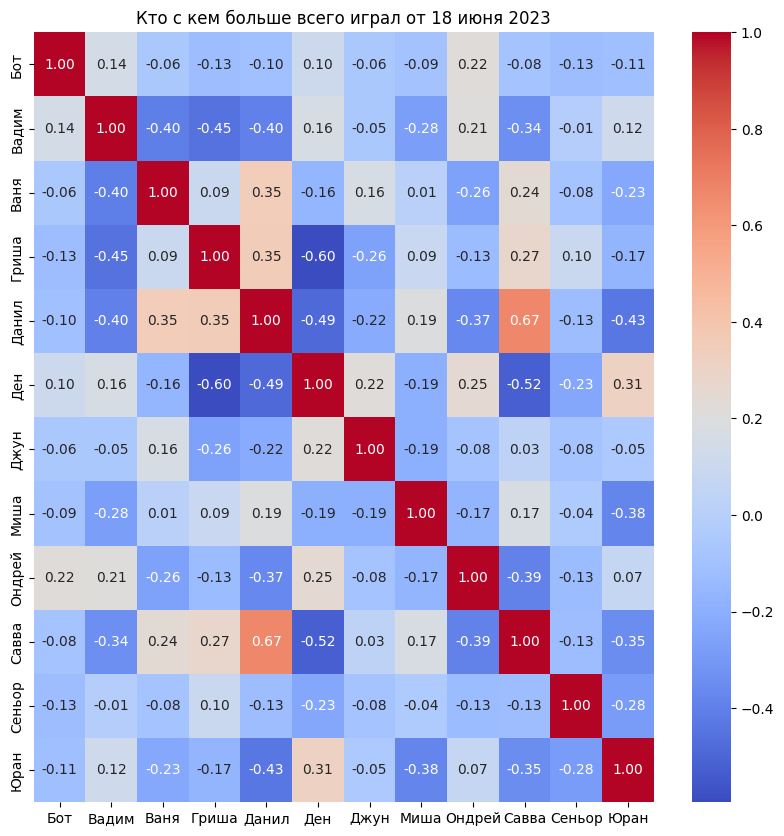

In [14]:
# plot  correlation between  players who won together
players_1team =  [player+"_team1" for player in players]

#  correlation between  players who won together
correlation = dataset[players_1team].corr()
# remove _team1 from the column names
correlation.columns = [col[:-6] for col in correlation.columns]
correlation.index = [col[:-6] for col in correlation.index]

plt.figure(figsize=(10, 10))
#  plot correlation matrix wit z title
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")

plt.title('Кто с кем больше всего играл от 18 июня 2023')


plt.show()

In [15]:
players = [player+"_team1" for player in players] + [player+"_team2" for player in players]

# split the dataset into train and test
train, test = train_test_split(dataset,  test_size=test_size, random_state=42)

# select the columns to predict
y_train = train['TeamWon']-1  # 0 or 1
y_test = test['TeamWon']-1 # 0 or 1

# select the columns to train the model
X_train = train[players]
w_train = train["Map_weight"]
X_test = test[players]
w_test = test["Map_weight"]

In [16]:
players

['Бот_team1',
 'Вадим_team1',
 'Ваня_team1',
 'Гриша_team1',
 'Данил_team1',
 'Ден_team1',
 'Джун_team1',
 'Миша_team1',
 'Ондрей_team1',
 'Савва_team1',
 'Сеньор_team1',
 'Юран_team1',
 'Бот_team2',
 'Вадим_team2',
 'Ваня_team2',
 'Гриша_team2',
 'Данил_team2',
 'Ден_team2',
 'Джун_team2',
 'Миша_team2',
 'Ондрей_team2',
 'Савва_team2',
 'Сеньор_team2',
 'Юран_team2']

In [17]:
#  create a model
model = keras.Sequential([
    keras.layers.Dense(70, input_shape=(len(players),), activation='relu'),
    keras.layers.Dense(70, activation='relu'),
    keras.layers.Dense(70, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',

              # metrics=['accuracy'],
              weighted_metrics=['accuracy']
              )
# train the model
model.fit(X_train,
          y_train, 
          sample_weight=w_train,
          validation_split=0.1, 
          epochs=10)
# test the model
print ("")
print ("Test")
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)

2024-03-14 15:02:42.458517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:42.463610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:42.463681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:42.466324: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:42.466370: I tensorflow/compile

Epoch 1/10


2024-03-14 15:02:45.257300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-14 15:02:45.261014: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f16edff4b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-14 15:02:45.261053: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-03-14 15:02:45.265936: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-14 15:02:45.282814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8800
2024-03-14 15:02:45.358798: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 

2/2 [==============================] - 2s 213ms/step - loss: 0.6414 - accuracy: 0.3611 - val_loss: 0.5997 - val_accuracy: 0.4571
Epoch 2/10
2/2 [==============================] - 0s 31ms/step - loss: 0.6136 - accuracy: 0.6250 - val_loss: 0.5880 - val_accuracy: 0.6286
Epoch 3/10
2/2 [==============================] - 0s 28ms/step - loss: 0.5884 - accuracy: 0.7812 - val_loss: 0.5783 - val_accuracy: 0.6286
Epoch 4/10
2/2 [==============================] - 0s 31ms/step - loss: 0.5645 - accuracy: 0.7986 - val_loss: 0.5698 - val_accuracy: 0.4857
Epoch 5/10
2/2 [==============================] - 0s 30ms/step - loss: 0.5462 - accuracy: 0.7604 - val_loss: 0.5647 - val_accuracy: 0.4857
Epoch 6/10
2/2 [==============================] - 0s 27ms/step - loss: 0.5282 - accuracy: 0.7257 - val_loss: 0.5609 - val_accuracy: 0.4857
Epoch 7/10
2/2 [==============================] - 0s 29ms/step - loss: 0.5113 - accuracy: 0.7257 - val_loss: 0.5581 - val_accuracy: 0.4857
Epoch 8/10
2/2 [=====================

In [18]:
all_results = []
# add bots to the present players if there are less than 8 players
while len(present_players) < 8:
      present_players = present_players + ["Бот"]
print ('present_players are', present_players)


for i in range(0, len(present_players)):
    for j in range(i+1, len(present_players)):
        for k in range(j+1, len(present_players)):
            for l in range(k+1, len(present_players)):
                                team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                                # subtract team 1 player form list of present players, "Бот" can be used many times
                                team2 = [x for x in present_players if x not in team1]
                                # if team 2 has less than 4 players, add "Бот" to team 2
                                while len(team2) < 4:
                                    team2 = team2 + ["Бот"]

                                # create a row with the players
                                row = np.zeros(len(players))
                                for player in team1:
                                    row[players.index(player+"_team1")] = 1
                                for player in team2:
                                    row[players.index(player+"_team2")] = 1
                                row = row.reshape(1, -1)
                                
                               
                                # predict the result
                                result = model.predict(row, verbose=0)
                                all_results.append((team1, team2, result))
# sort the results
all_results.sort(key=lambda x: x[2], reverse=True)
print ("")
print (len(all_results))


present_players are ['Вадим', 'Джун', 'Гриша', 'Ден', 'Сеньор', 'Миша', 'Данил', 'Ваня']

70


In [19]:
# print the results
for i in range(0, len(all_results)):
    print(all_results[i][0], "vs", all_results[i][1], ":", all_results[i][2][0][0])

['Вадим', 'Джун', 'Гриша', 'Ден'] vs ['Сеньор', 'Миша', 'Данил', 'Ваня'] : 0.7465998
['Вадим', 'Джун', 'Ден', 'Ваня'] vs ['Гриша', 'Сеньор', 'Миша', 'Данил'] : 0.7461508
['Вадим', 'Джун', 'Ден', 'Сеньор'] vs ['Гриша', 'Миша', 'Данил', 'Ваня'] : 0.7421102
['Вадим', 'Джун', 'Сеньор', 'Ваня'] vs ['Гриша', 'Ден', 'Миша', 'Данил'] : 0.73904496
['Вадим', 'Гриша', 'Ден', 'Данил'] vs ['Джун', 'Сеньор', 'Миша', 'Ваня'] : 0.7366375
['Вадим', 'Гриша', 'Миша', 'Данил'] vs ['Джун', 'Ден', 'Сеньор', 'Ваня'] : 0.7360371
['Вадим', 'Гриша', 'Ден', 'Сеньор'] vs ['Джун', 'Миша', 'Данил', 'Ваня'] : 0.73322237
['Вадим', 'Гриша', 'Сеньор', 'Ваня'] vs ['Джун', 'Ден', 'Миша', 'Данил'] : 0.73230654
['Вадим', 'Гриша', 'Сеньор', 'Данил'] vs ['Джун', 'Ден', 'Миша', 'Ваня'] : 0.73190475
['Вадим', 'Джун', 'Гриша', 'Ваня'] vs ['Ден', 'Сеньор', 'Миша', 'Данил'] : 0.7316707
['Вадим', 'Ден', 'Миша', 'Данил'] vs ['Джун', 'Гриша', 'Сеньор', 'Ваня'] : 0.73091394
['Вадим', 'Джун', 'Миша', 'Ваня'] vs ['Гриша', 'Ден', 'Сеньо

In [20]:
#  take the middle of the list
middle_nn = len(all_results) // 2
print ("best team by median:")
print(all_results[middle_nn][0], "vs", all_results[middle_nn][1], "with output=", all_results[middle_nn][2][0][0])

#second best team
print ("second best team by median:")
print(all_results[middle_nn-1][0], "vs", all_results[middle_nn-1][1], "with output=", all_results[middle_nn-1][2][0][0])



best team by median:
['Гриша', 'Ден', 'Миша', 'Данил'] vs ['Вадим', 'Джун', 'Сеньор', 'Ваня'] with output= 0.67581666
second best team by median:
['Джун', 'Гриша', 'Ден', 'Данил'] vs ['Вадим', 'Сеньор', 'Миша', 'Ваня'] with output= 0.676951


In [21]:
# take closest to 50% result
closest = min(all_results, key=lambda x: abs(x[2] - 0.5))
print ("best team by model 50% result:")
print(closest[0], "vs", closest[1], "with output=", closest[2][0][0])

best team by model 50% result:
['Ден', 'Сеньор', 'Данил', 'Ваня'] vs ['Вадим', 'Джун', 'Гриша', 'Миша'] with output= 0.5598416


In [22]:
# make the list of players from table above
old_method_dataset = pd.DataFrame({
    "Player": ["Сеньор", "Гриша", "Миша", "Ваня", "Бот", "Джун", "Данил", "Вадим", "Ондрей", "Юран", "Ден", "Савва"],
    "Games":  [      21,      22,     19,     18,     6,      8,      16,      24,       12,     10,    18,      10],
    "Wins":   [      14,      14,     11,     10,     3,      4,       8,      10,        5,      4,     6,       3]
})

old_method_dataset["Winrate"] = old_method_dataset["Wins"] / old_method_dataset["Games"]
old_method_dataset = old_method_dataset.sort_values(by="Winrate", ascending=False)
old_method_dataset

,Player,Games,Wins,Winrate
0,Сеньор,21,14,0.666667
1,Гриша,22,14,0.636364
2,Миша,19,11,0.578947
3,Ваня,18,10,0.555556
4,Бот,6,3,0.500000
5,Джун,8,4,0.500000
6,Данил,16,8,0.500000
7,Вадим,24,10,0.416667
8,Ондрей,12,5,0.416667
9,Юран,10,4,0.400000


In [23]:
# based on present players and winrate, loop over all possible teams and calculate the total winrate
#  and print the best team
all_teams = []
for i in range(0, len(present_players)):
    for j in range(i+1, len(present_players)):
        for k in range(j+1, len(present_players)):
            for l in range(k+1, len(present_players)):
                team1 = [present_players[i], present_players[j], present_players[k], present_players[l]]
                team2 = [x for x in present_players if x not in team1]
                while len(team2) < 4:
                    team2.append("Бот")
                team1_winrate = old_method_dataset[old_method_dataset["Player"].isin(team1)]["Winrate"].sum()
                team2_winrate = old_method_dataset[old_method_dataset["Player"].isin(team2)]["Winrate"].sum()
                all_teams.append((team1, team1_winrate, team2, team2_winrate))
all_teams.sort(key=lambda x: x[1], reverse=True)
print ("present_players are", present_players)
print ("")
# print the results
for i in range(0, len(all_teams)):
    print(all_teams[i][0], "with winrate=", all_teams[i][1], "vs", all_teams[i][2], "with winrate=", all_teams[i][3])
# median
middle = len(all_teams) // 2
print ("best team by median:")
print(all_teams[middle][0], "with points=", all_teams[middle][3],"vs", all_teams[middle][1], "with points=", all_teams[middle][2])


present_players are ['Вадим', 'Джун', 'Гриша', 'Ден', 'Сеньор', 'Миша', 'Данил', 'Ваня']

['Гриша', 'Сеньор', 'Миша', 'Ваня'] with winrate= 2.437533227006911 vs ['Вадим', 'Джун', 'Ден', 'Данил'] with winrate= 1.75
['Джун', 'Гриша', 'Сеньор', 'Миша'] with winrate= 2.381977671451356 vs ['Вадим', 'Ден', 'Данил', 'Ваня'] with winrate= 1.8055555555555556
['Гриша', 'Сеньор', 'Миша', 'Данил'] with winrate= 2.381977671451356 vs ['Вадим', 'Джун', 'Ден', 'Ваня'] with winrate= 1.8055555555555556
['Джун', 'Гриша', 'Сеньор', 'Ваня'] with winrate= 2.3585858585858586 vs ['Вадим', 'Ден', 'Миша', 'Данил'] with winrate= 1.8289473684210527
['Гриша', 'Сеньор', 'Данил', 'Ваня'] with winrate= 2.3585858585858586 vs ['Вадим', 'Джун', 'Ден', 'Миша'] with winrate= 1.8289473684210527
['Джун', 'Гриша', 'Сеньор', 'Данил'] with winrate= 2.3030303030303028 vs ['Вадим', 'Ден', 'Миша', 'Ваня'] with winrate= 1.8845029239766082
['Джун', 'Сеньор', 'Миша', 'Ваня'] with winrate= 2.3011695906432745 vs ['Вадим', 'Гриша', 'Де

In [32]:
#  print best median result from old method and new method
print ("Neural Network")
print ("best team by median:")
print(all_results[middle_nn][0], "vs", all_results[middle_nn][1], "with output=", all_results[middle_nn][2][0][0])
# second best
print ("second best:")
print(all_results[middle_nn-1][0], "vs", all_results[middle_nn-1][1], "with output=", all_results[middle_nn-1][2][0][0])


print ("  ")
print ("Old Method")
print ("best team:")
#  format floating values up  to 2 decimal places
print(all_teams[middle][0], "with points=", round(all_teams[middle][1], 2), "vs", all_teams[middle][2], "with points=", round(all_teams[middle][3], 2))

# second best
print ("second best:")
print(all_teams[middle-2][0], "with points=", round(all_teams[middle-2][1], 2), "vs", all_teams[middle-2][2], "with points=", round(all_teams[middle-2][3], 2))


Neural Network
best team by median:
['Гриша', 'Ден', 'Миша', 'Данил'] vs ['Вадим', 'Джун', 'Сеньор', 'Ваня'] with output= 0.67581666
second best:
['Джун', 'Гриша', 'Ден', 'Данил'] vs ['Вадим', 'Сеньор', 'Миша', 'Ваня'] with output= 0.676951
  
Old Method
best team:
['Вадим', 'Джун', 'Сеньор', 'Данил'] with points= 2.08 vs ['Гриша', 'Ден', 'Миша', 'Ваня'] with points= 2.1
second best:
['Вадим', 'Гриша', 'Данил', 'Ваня'] with points= 2.11 vs ['Джун', 'Ден', 'Сеньор', 'Миша'] with points= 2.08
